# Introduction to Deep Learning 
## Professor Vahid Tarokh
### Students: Ashley, John, Ryan, Julian
#### Team Project
#### C-VAE on COCO

##### Disclaimer: ChatGPT was used for creating the solution to the project assignment.
##### Disclaimer: Solution partly based on HW5.

### NOTE: This code was run in another jupyter notebook (submitted as *adding_approach_coco_cvae*) that has more computational efficiency. The results shown here are merely exemplary as only a really small subsample of COCO is used here. Additionally, the number of epochs for training is reduced here.

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim import Adam, RAdam

import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance

from torchvision.datasets import CocoCaptions
from pycocotools.coco import COCO
from typing import List, Union
from tqdm import tqdm
import json
import clip
import requests
import random
import zipfile

In [2]:
# setting seed for replicability
SEED = 12062024
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# device & tensor configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

**Load COCO dataset including annotations**

We start to define helper functions. The data is loaded using those functions subsequently.

In [3]:
def download_and_extract(url, save_path, extract_to):
    """Download and extract a zip file."""

    if not os.path.exists(save_path):
        print(f"Downloading {url}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(save_path, 'wb') as file, tqdm(
            desc=f"Downloading {os.path.basename(save_path)}",
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as pbar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                pbar.update(size)

    # Extract the ZIP file
    if not os.path.exists(extract_to):
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Extracted {os.path.basename(save_path)} to {extract_to}")
    else:
        print(f"Already downloaded and zip extracted.")


def download_coco_data(urls, base_dir='coco_data'):
    """Download COCO dataset images and annotations."""

    # Paths to save files
    annotations_dir = os.path.join(base_dir, "annotations")
    train_images_dir = os.path.join(base_dir, "train2014")
    val_images_dir = os.path.join(base_dir, "val2014")

    # Download and extract annotations
    download_and_extract(urls["annotations"], 
                         os.path.join(base_dir, "annotations_trainval2014.zip"), 
                         base_dir)

    # Download and extract training images
    download_and_extract(urls["train_images"], 
                         os.path.join(base_dir, "train2014.zip"), 
                         base_dir)

    # Download and extract validation images
    download_and_extract(urls["val_images"], 
                         os.path.join(base_dir, "val2014.zip"), 
                         base_dir)

    print("COCO dataset download and extraction complete!")
    return train_images_dir, val_images_dir, os.path.join(annotations_dir, 'captions_train2014.json'), os.path.join(annotations_dir, 'captions_val2014.json')



def load_coco_captions(annotation_file, img_id):
    """Load COCO captions and return annotation for the specified image id."""
    # Initialize COCO API for captions
    coco = COCO(annotation_file)

    # Get all image IDs
    img_ids = coco.getImgIds()

    # Get annotation IDs for a sample image
    #sample_img_id = img_ids[0]
    sample_img_id = img_id
    ann_ids = coco.getAnnIds(imgIds=sample_img_id)

    # Get the annotations
    anns = coco.loadAnns(ann_ids)

    # Get image info
    img_info = coco.loadImgs(sample_img_id)[0]

    return {
        'total_images': len(img_ids),
        'sample_image_info': img_info,
        'sample_captions': [ann['caption'] for ann in anns]
    }


In [4]:
# Download COCO dataset to the following directory
base_dir = 'coco_dataset_2014'

# URLs for COCO data
urls = {
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
    "train_images": "http://images.cocodataset.org/zips/train2014.zip",
    "val_images": "http://images.cocodataset.org/zips/val2014.zip",
}

train_images_dir, val_images_dir, annotations_train_file, annotations_val_file = download_coco_data(urls, base_dir)

print(f"Training images directory: {train_images_dir}")
print(f"Validation images directory: {val_images_dir}")
print(f"Annotations file for Training images: {annotations_train_file}")
print(f"Annotations file for Validation images: {annotations_val_file}")

# Example Annotation
coco = COCO(annotations_train_file) # Initialize COCO API for captions
img_ids = coco.getImgIds()
example_id = img_ids[0]
data = load_coco_captions(annotations_train_file, example_id)
print(f"Total number of images: {data['total_images']}")
print("\nSample image info:")
print(json.dumps(data['sample_image_info'], indent=2))
print("\nSample captions for this image:")
for idx, caption in enumerate(data['sample_captions'], 1):
    print(f"{idx}. {caption}")

Already downloaded and zip extracted.
Already downloaded and zip extracted.
Already downloaded and zip extracted.
COCO dataset download and extraction complete!
Training images directory: coco_dataset_2014/train2014
Validation images directory: coco_dataset_2014/val2014
Annotations file for Training images: coco_dataset_2014/annotations/captions_train2014.json
Annotations file for Validation images: coco_dataset_2014/annotations/captions_val2014.json
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Total number of images: 82783

Sample image info:
{
  "license": 5,
  "file_name": "COCO_train2014_000000057870.jpg",
  "coco_url": "http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg",
  "height": 480,
  "width": 640,
  "date_captured": "2013-11-14 16:28:13",
  "flickr_url": "http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg",
  "id": 57870
}

**CLIP Encoder**

In [5]:
class CLIPEncoder(nn.Module):
    def __init__(self, model_name: str = "ViT-B/16", device: str = "cuda" if torch.cuda.is_available() else "cpu"):
        super().__init__()
        self.device = device

        # Load CLIP
        self.model, _ = clip.load(model_name, device=device)

        # freeze model
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.eval()

    def encode_text(self, texts: Union[str, List[str]], normalize: bool = True) -> torch.Tensor:
        # encode texts, takes a string or list of strings, returns encoding tensor
        # Convert single string to list
        if isinstance(texts, str):
            texts = [texts]

        # Tokenize and encode
        with torch.no_grad():
            text_tokens = clip.tokenize(texts).to(self.device)
            text_features = self.model.encode_text(text_tokens)

            if normalize:
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        return text_features

    # 512
    def get_embedding_dim(self) -> int:
        # return embedding shape
        return self.model.text_projection.shape[1]

In [6]:
### Example use of CLIP Encoder

# Init encoder
clip_encoder = CLIPEncoder().to(device)

# Example
texts = [
    "a photo of a dog running in the park",
    "a painting of a sunset over mountains",
    "a close-up photo of a red rose"
]

# Get embeddings
embeddings = clip_encoder.encode_text(texts)
print(f"Embedding shape: {embeddings.shape}")

# Get single text embedding
single_embedding = clip_encoder.encode_text("a photo of a cat")
print(f"\nSingle embedding shape: {single_embedding.shape}")

Embedding shape: torch.Size([3, 512])

Single embedding shape: torch.Size([1, 512])


We can see that one text emdding using CLIP has the dimension of 512.

**Load COCO dataset into dataloader**

In [7]:
# batch size
batch_size = 128
image_size = 64 # image size of the resized picture


# as each image comes with several annotations, we modify the dataset behavior
# only one random annotation should be extracted per image
class RandomCocoCaptions(CocoCaptions):
    def __getitem__(self, index):
        """
        Override the default __getitem__ to return one random caption instead of all captions.
        """
        image, captions = super().__getitem__(index)
        random_caption = random.choice(captions)
        return image, random_caption


# transforming data while loading
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images to [-1, 1]
])

train_dataset = RandomCocoCaptions(root=train_images_dir,
                                    annFile=annotations_train_file,
                                    transform=transform)

val_dataset = RandomCocoCaptions(root=val_images_dir,
                                    annFile=annotations_val_file,
                                    transform=transform)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


**Visualize an Image of the Dataset**

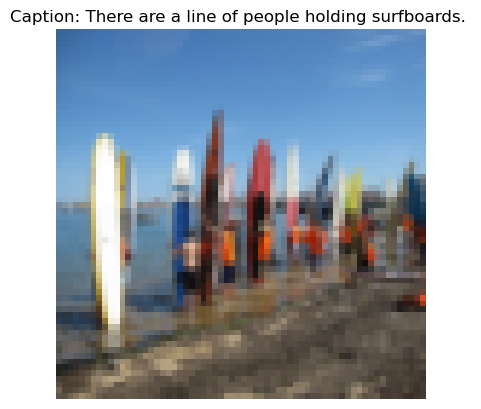

In [8]:
# Get the first batch from the DataLoader
data_iter = iter(train_dataloader)
images, captions = next(data_iter)

# Randomly select an image and caption
first_image = images[3]
first_caption = captions[3]

# Denormalize the image to map back to [0, 1] range
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
first_image = first_image * std + mean

# Convert tensor to a NumPy array and display it
plt.imshow(to_pil_image(first_image))
plt.title(f"Caption: {first_caption}")
plt.axis('off')
plt.show()

We see that the caption matches the image, indicating that we loaded the data and annoations correctly.

**Preprocess Dataset**

We subsample the data for the sake of improving the computational time for training.

In [9]:
# Original size of the training dataset
train_size = len(train_dataset)
print(f"Original number of images in training dataset: {train_size}")

# Calculate the size of the 10% subset
subset_size = int(train_size * 0.01) # changed to 1% for the sake of computational time (see NOTE at the top of file)
remaining_size = train_size - subset_size

# Split the dataset
train_subset, _ = random_split(train_dataset, [subset_size, remaining_size])
print(f"Number of images in sampled subset: {len(train_subset)}")

# Create new DataLoader for the training subset
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)

Original number of images in training dataset: 82783
Number of images in sampled subset: 827


We repeat this process for the validation set.

In [10]:
# Original size of the validation dataset
val_size = len(val_dataset)
print(f"Original number of images in validation dataset: {val_size}")

# Calculate the size of the 10% subset
subset_size = int(val_size * 0.01) # changed to 1% for the sake of computational time (see NOTE at the top of file)
remaining_size = val_size - subset_size

# Split the dataset
val_subset, _ = random_split(val_dataset, [subset_size, remaining_size])
print(f"Number of images in sampled subset: {len(val_subset)}")

# Create new DataLoader for the validation subset
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0)

Original number of images in validation dataset: 40504
Number of images in sampled subset: 405


### C-VAE

Solution based on lecture slides and *Part_10a_VAE.ipynb* from the discussion section.

In [11]:
class ConditionalVAE(nn.Module):
    def __init__(self, text_embedding_dim=512, latent_dim=256, image_channels=3, image_size=64):
        """
        Args:
            text_embedding_dim (int): Dimension of text embeddings.
            latent_dim (int): Dimension of latent space.
            image_channels (int): Number of channels in the output image.
            image_size (int): Size (height and width) of the generated images (assumes square images).
        """

        super().__init__()
        self.text_embedding_dim = text_embedding_dim
        self.latent_dim = latent_dim
        self.image_channels = image_channels
        self.image_size = image_size

        #### for 64x64 images
        # Encoder:
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )

        self.text_processor_encoder = nn.Linear(text_embedding_dim, 256 * (image_size // 8) ** 2)

        self.latent_processor = nn.Linear(256 * (image_size // 8) ** 2, 1024)
        self.mu = nn.Linear(1024, latent_dim)
        self.logvar = nn.Linear(1024, latent_dim)

        # Decoder:
        self.decoder_input = nn.Linear(latent_dim, 256 * (image_size // 8) ** 2)
        self.text_processor_decoder = nn.Linear(text_embedding_dim, 256 * (image_size // 8) ** 2)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Tanh()  # Outputs normalized to [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + sigma * epsilon."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, images, text_embedding):
        """Encoder forward pass."""
        image_features = self.encoder(images)
        processed_text = self.text_processor_encoder(text_embedding)
        combined_features = image_features + processed_text
        latent_space = self.latent_processor(combined_features)
        mu = self.mu(latent_space)
        logvar = self.logvar(latent_space)

        return mu, logvar

    def decode(self, z, text_embedding):
        """Decoder forward pass."""
        z_processed = self.decoder_input(z)
        text_processed = self.text_processor_decoder(text_embedding)
        decoder_input = z_processed + text_processed
        batch_size_dynamic = decoder_input.size(0)
        decoder_input = decoder_input.view(batch_size_dynamic, 256, self.image_size // 8, self.image_size // 8)
        reconstructed_images = self.decoder(decoder_input)
        return reconstructed_images

    def forward(self, images, text_embedding):
        """
        Forward pass through the cVAE.
        Args:
            text_embedding (torch.Tensor): Text embeddings of shape (batch_size, text_embedding_dim).
            images (torch.Tensor, optional): Ground-truth images of shape (batch_size, image_channels, image_size, image_size).
        Returns:
            reconstructed_images (torch.Tensor): Generated images.
            mu (torch.Tensor): Mean of latent distribution.
            logvar (torch.Tensor): Log variance of latent distribution.
        """
        mu, logvar = self.encode(images, text_embedding)
        z = self.reparameterize(mu, logvar)
        reconstructed_images = self.decode(z, text_embedding)
        return reconstructed_images, mu, logvar


**Loss function:**

In [12]:
def loss_function(recon_x, x, mu, logvar):
    """Computes the loss = -ELBO = Negative Log-Likelihood + KL Divergence.

    Args:
        recon_x: Decoder output.
        x: Ground truth.
        mu: Mean of Z
        logvar: Log-Variance of Z

    Returns:
        loss (torch.Tensor): Total loss (reconstruction + KL divergence).
    """
    # BCE as Negative Log-likelihood as data is normalized to range [0,1]
    #BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # Alternative: L2 reconstruction error (MSE as the negative log-likelihood term for Gaussian likelihood)
    MSE = F.mse_loss(recon_x, x, reduction='sum') 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    #return BCE + KLD
    return MSE + KLD


**Train and Test Function:**

In [13]:
def train(model, device, train_loader, optimizer, epoch, batch_size):
    train_loss = 0
    model.train()
    for batch_idx, (data, captions) in enumerate(train_loader):

        optimizer.zero_grad()

        # convert the annoation to text embedding
        text_embeddings = clip_encoder.encode_text(captions)

        # forward step
        output, mu, logvar = model(data, text_embeddings)

        # backward step
        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
 
        #if batch_idx == 0:
            #print('(Epoch {}) Train[  0%]: Loss: {:.4f}'.format(epoch, train_loss/(batch_size))) # avg. loss per sample
    
    print('(Epoch {}) Train: Avg. Loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))  # avg. loss per sample
    
    # visualize reconstructed images after very 5th epoch to confirm the model is learning
    if epoch % 5 == 0:
        with torch.no_grad():
            recon_images, _, _ = model(data[:4], text_embeddings[:4])
            recon_images = recon_images * std + mean
            fig, axes = plt.subplots(1, 4, figsize=(12, 4))
            for i, ax in enumerate(axes):
                ax.imshow(recon_images[i].permute(1, 2, 0).cpu().numpy(), interpolation='nearest')
                ax.axis('off')
            plt.tight_layout()
            plt.show()  
        
    train_loss = train_loss / len(train_loader.dataset) # return avg. loss per sample
    return train_loss


def test(model, device, loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, captions in loader:
            
            text_embeddings = clip_encoder.encode_text(captions)
            
            output, mu, logvar = model(data, text_embeddings)
                
            loss = loss_function(output, data, mu, logvar)
            test_loss += loss.item() # sum up batch loss
            
    test_loss = test_loss / len(loader.dataset) # avg. loss per sample
    print('(Epoch {}) Test: Avg. Loss: {:.4f}'.format(epoch, test_loss))
    return test_loss

### Metrics

**Mean squared error (MSE):**

In [14]:
def compute_mse(model, data_loader):

    model.eval()
    mse_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, captions in data_loader:

            # convert annoation to text embedding
            text_embeddings = clip_encoder.encode_text(captions)

            # reconstruct the data using C-VAE
            reconstructed_data, _, _ = model(data, text_embeddings)

            # compute the MSE for the batch
            batch_size = data.size(0)
            batch_mse = F.mse_loss(reconstructed_data, data, reduction='sum')
            mse_loss += batch_mse.item()
            total_samples += batch_size

    # compute and return the average MSE
    average_mse = mse_loss / total_samples
    return average_mse

**Structural similarity index measure (SSIM):**

In addition to MSE we use SSIM as a measure of similarity between images. It uses luminance, constract, and structure of images.

In [15]:
def compute_average_ssim(model, data_loader):
    model.eval()
    total_samples = 0
    total_ssim = 0.0

    # Initialize the SSIM metric
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # Assumes input data is in [0, 1]

    with torch.no_grad():
        for data, captions in data_loader:

            # convert annoation to text embedding
            text_embeddings = clip_encoder.encode_text(captions)

            # reconstruct the data using C-VAE
            reconstructed_data, _, _ = model(data, text_embeddings)

            # Compute SSIM for the batch
            batch_ssim = ssim(reconstructed_data, data)
            total_ssim += batch_ssim.item() * data.size(0)
            total_samples += data.size(0)

    # Compute average SSIM
    average_ssim = total_ssim / total_samples
    return average_ssim

**Fréchet inception distance (FID):**

Additionally, we consider the FID as an additional metric which has the purpose to assess the quality of generated images.

In [16]:
def compute_fid(model, data_loader):
    model.eval()

    # Initialize the FID metric
    fid = FrechetInceptionDistance(feature=2048).to(device)  # Feature layer 2048 corresponds to InceptionV3

    with torch.no_grad():
        for data, captions in data_loader:
            # convert annoation to text embedding
            text_embeddings = clip_encoder.encode_text(captions)
          
            # reconstruct the data using C-VAE
            reconstructed_data, _, _ = model(data, text_embeddings)

            # Scale images to have pixel values in the range [0, 255] and convert to unsigned 8-bit integers
            data = (data * 255).clamp(0, 255).to(torch.uint8)
            reconstructed_data = (reconstructed_data * 255).clamp(0, 255).to(torch.uint8)

            # Add fake and real data to fid object
            fid.update(data, real=True)
            fid.update(reconstructed_data, real=False)

    fid_score = fid.compute()
    return fid_score.item()

**Hyperparamters and Training Set up:**

In [17]:
###################################
# dimensions
text_embedding_dim = 512
latent_dim = 256
image_channels = 3

###################################
# further parameters
num_epochs_tuning = 5
num_epochs = 20
learning_rate = 1e-4

###################################
# hyperparamter for the L2 penalty (weight decay)
weight_decay_values = [0, 1e-3]  # weight decay values to test
best_weight_decay = None
best_val_loss = float('inf')


**Hyperparameter Tuning:**

Due to computational time, we only conduct a small hyperparameter tuning (see C-VAE for fashion MNIST for a more extensive tuning). here, we will simply test two weight decay values on the validation set for a few epochs to see how they differ in performance.

****************************************
Testing weight_decay=0
****************************************
(Epoch 1) Train: Avg. Loss: 3676.2462
(Epoch 2) Train: Avg. Loss: 3431.3521
(Epoch 3) Train: Avg. Loss: 3073.3826
(Epoch 4) Train: Avg. Loss: 2713.2078
(Epoch 5) Train: Avg. Loss: 2461.4512


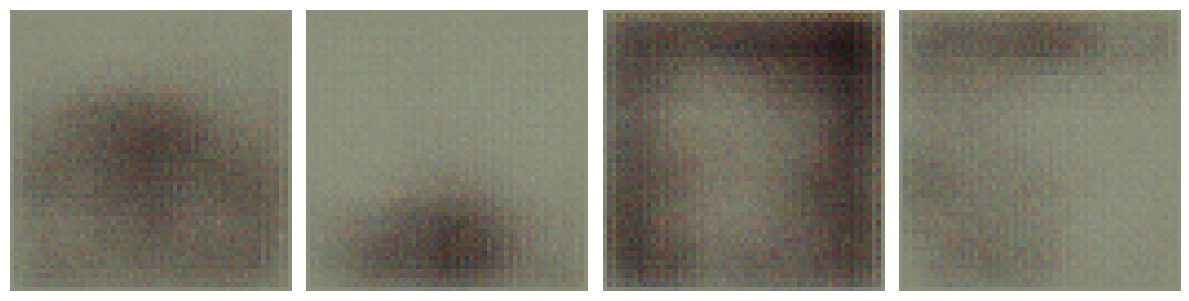

(Epoch 5) Test: Avg. Loss: 2402.1165
Validation loss for weight_decay=0: 2402.116541280864
****************************************
Testing weight_decay=0.001
****************************************
(Epoch 1) Train: Avg. Loss: 3425.5353
(Epoch 2) Train: Avg. Loss: 3283.5763
(Epoch 3) Train: Avg. Loss: 3049.9040
(Epoch 4) Train: Avg. Loss: 2765.3748
(Epoch 5) Train: Avg. Loss: 2502.7571


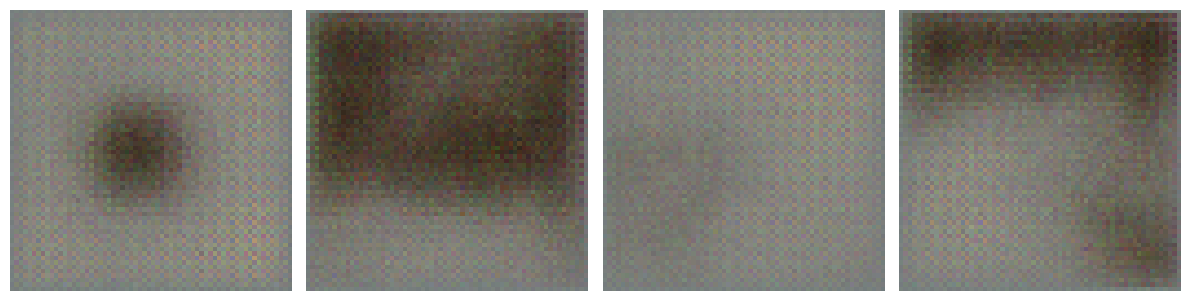

(Epoch 5) Test: Avg. Loss: 2451.7693
Validation loss for weight_decay=0.001: 2451.769319058642
****************************************
Best weight_decay: 0 with validation loss: 2402.116541280864


In [18]:
for weight_decay in weight_decay_values:
    print(40*"*")
    print(f"Testing weight_decay={weight_decay}")
    print(40*"*")
    cvae = ConditionalVAE(text_embedding_dim, latent_dim, image_channels, image_size).to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate, weight_decay=weight_decay)
    #optimizer = RAdam(cvae.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # train for a specified number of epochs
    for epoch in range(1, num_epochs_tuning + 1):
        train(cvae, device, train_dataloader, optimizer, epoch, batch_size)
        
    val_loss = test(cvae, device, val_dataloader, epoch)
    print(f"Validation loss for weight_decay={weight_decay}: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weight_decay = weight_decay

print(40*"*")
print(f"Best weight_decay: {best_weight_decay} with validation loss: {best_val_loss}")


**Re-train on the full training set with the best weight decay**

(Epoch 1) Train: Avg. Loss: 3574.2611
(Epoch 1) Test: Avg. Loss: 3572.4996
(Epoch 1) Mean Squared Reconstruction Error (Train): 3475.8872
(Epoch 1) Mean Squared Reconstruction Error (Test): 3572.0625
(Epoch 2) Train: Avg. Loss: 3391.1095
(Epoch 2) Test: Avg. Loss: 3422.6118
(Epoch 2) Mean Squared Reconstruction Error (Train): 3331.7858
(Epoch 2) Mean Squared Reconstruction Error (Test): 3415.2790
(Epoch 3) Train: Avg. Loss: 3167.8445
(Epoch 3) Test: Avg. Loss: 3154.4364
(Epoch 3) Mean Squared Reconstruction Error (Train): 3083.6661
(Epoch 3) Mean Squared Reconstruction Error (Test): 3135.5423
(Epoch 4) Train: Avg. Loss: 2882.9492
(Epoch 4) Test: Avg. Loss: 2832.4297
(Epoch 4) Mean Squared Reconstruction Error (Train): 2755.8026
(Epoch 4) Mean Squared Reconstruction Error (Test): 2793.5719
(Epoch 5) Train: Avg. Loss: 2560.2339


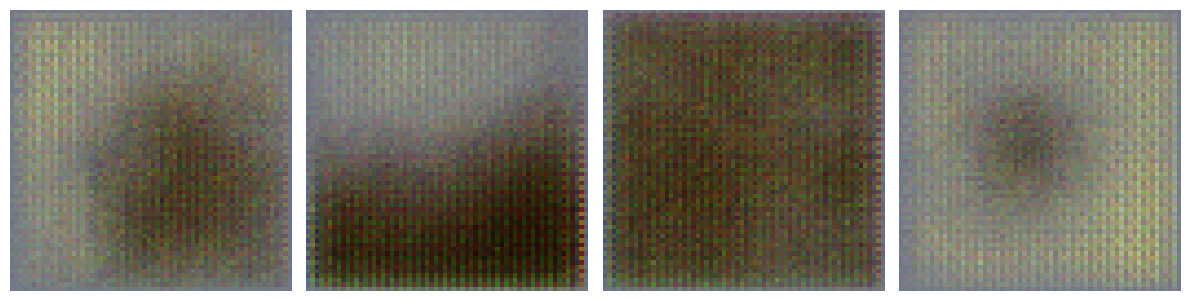

(Epoch 5) Test: Avg. Loss: 2434.3723
(Epoch 5) Mean Squared Reconstruction Error (Train): 2347.8775
(Epoch 5) Mean Squared Reconstruction Error (Test): 2358.4523
(Epoch 6) Train: Avg. Loss: 2321.7004
(Epoch 6) Test: Avg. Loss: 2209.8131
(Epoch 6) Mean Squared Reconstruction Error (Train): 2100.5364
(Epoch 6) Mean Squared Reconstruction Error (Test): 2119.5036
(Epoch 7) Train: Avg. Loss: 2104.3165
(Epoch 7) Test: Avg. Loss: 2033.8362
(Epoch 7) Mean Squared Reconstruction Error (Train): 1911.7417
(Epoch 7) Mean Squared Reconstruction Error (Test): 1935.7790
(Epoch 8) Train: Avg. Loss: 1893.3424
(Epoch 8) Test: Avg. Loss: 1867.2175
(Epoch 8) Mean Squared Reconstruction Error (Train): 1705.0971
(Epoch 8) Mean Squared Reconstruction Error (Test): 1742.7341
(Epoch 9) Train: Avg. Loss: 1753.5385
(Epoch 9) Test: Avg. Loss: 1737.0026
(Epoch 9) Mean Squared Reconstruction Error (Train): 1575.3206
(Epoch 9) Mean Squared Reconstruction Error (Test): 1618.1410
(Epoch 10) Train: Avg. Loss: 1631.8427

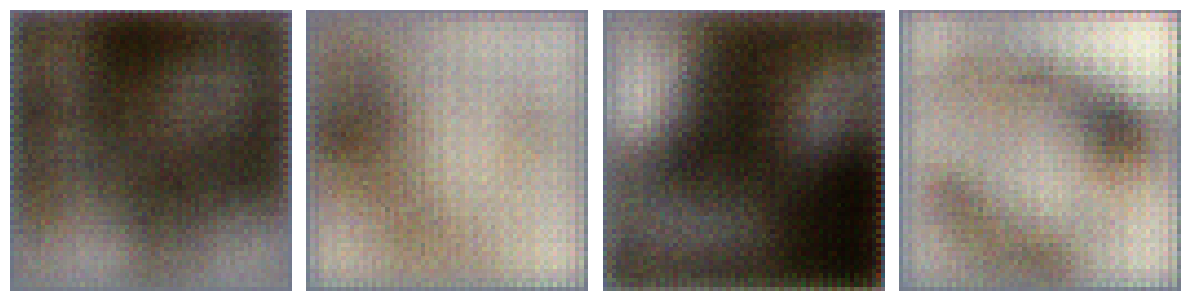

(Epoch 10) Test: Avg. Loss: 1597.4134
(Epoch 10) Mean Squared Reconstruction Error (Train): 1425.1823
(Epoch 10) Mean Squared Reconstruction Error (Test): 1458.5460
(Epoch 11) Train: Avg. Loss: 1558.9749
(Epoch 11) Test: Avg. Loss: 1547.5644
(Epoch 11) Mean Squared Reconstruction Error (Train): 1381.9274
(Epoch 11) Mean Squared Reconstruction Error (Test): 1422.2424
(Epoch 12) Train: Avg. Loss: 1489.6491
(Epoch 12) Test: Avg. Loss: 1483.2838
(Epoch 12) Mean Squared Reconstruction Error (Train): 1322.0667
(Epoch 12) Mean Squared Reconstruction Error (Test): 1351.2285
(Epoch 13) Train: Avg. Loss: 1463.2398
(Epoch 13) Test: Avg. Loss: 1504.4536
(Epoch 13) Mean Squared Reconstruction Error (Train): 1341.6831
(Epoch 13) Mean Squared Reconstruction Error (Test): 1379.3863
(Epoch 14) Train: Avg. Loss: 1443.2452
(Epoch 14) Test: Avg. Loss: 1456.1315
(Epoch 14) Mean Squared Reconstruction Error (Train): 1283.1730
(Epoch 14) Mean Squared Reconstruction Error (Test): 1315.4545
(Epoch 15) Train: A

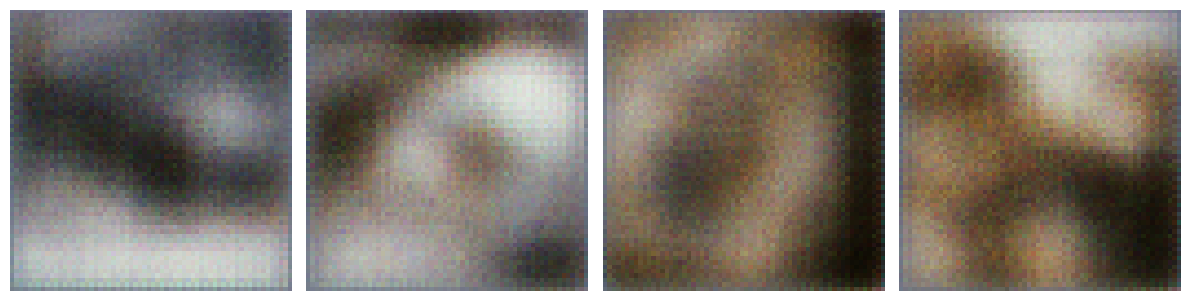

(Epoch 15) Test: Avg. Loss: 1415.9690
(Epoch 15) Mean Squared Reconstruction Error (Train): 1237.7032
(Epoch 15) Mean Squared Reconstruction Error (Test): 1275.8865
(Epoch 16) Train: Avg. Loss: 1379.1346
(Epoch 16) Test: Avg. Loss: 1420.2528
(Epoch 16) Mean Squared Reconstruction Error (Train): 1225.8161
(Epoch 16) Mean Squared Reconstruction Error (Test): 1274.2632
(Epoch 17) Train: Avg. Loss: 1344.8323
(Epoch 17) Test: Avg. Loss: 1346.9946
(Epoch 17) Mean Squared Reconstruction Error (Train): 1158.6732
(Epoch 17) Mean Squared Reconstruction Error (Test): 1201.6143
(Epoch 18) Train: Avg. Loss: 1310.0939
(Epoch 18) Test: Avg. Loss: 1372.0095
(Epoch 18) Mean Squared Reconstruction Error (Train): 1191.3077
(Epoch 18) Mean Squared Reconstruction Error (Test): 1236.9356
(Epoch 19) Train: Avg. Loss: 1294.3466
(Epoch 19) Test: Avg. Loss: 1358.8440
(Epoch 19) Mean Squared Reconstruction Error (Train): 1155.7843
(Epoch 19) Mean Squared Reconstruction Error (Test): 1210.1118
(Epoch 20) Train: A

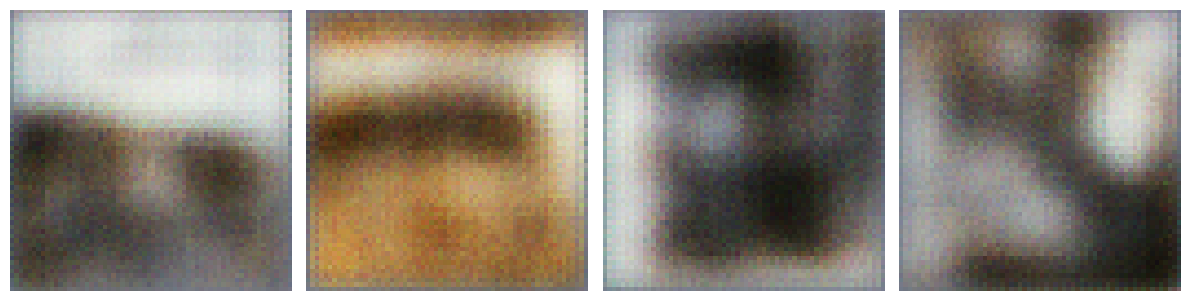

(Epoch 20) Test: Avg. Loss: 1306.1395
(Epoch 20) Mean Squared Reconstruction Error (Train): 1112.2941
(Epoch 20) Mean Squared Reconstruction Error (Test): 1159.8851


In [19]:
# create final model
cvae = ConditionalVAE(text_embedding_dim, latent_dim, image_channels, image_size).to(device)
# create final optimizer with best L2 penalty
optimizer = optim.Adam(cvae.parameters(),lr=learning_rate, weight_decay=best_weight_decay)

# Initialize lists to save loss and mse
train_losses = []
test_losses = []
train_mses = []
test_mses = []

for epoch in range(1, num_epochs + 1):
    
    train_loss = train(cvae, device, train_dataloader, optimizer, epoch, batch_size)
    test_loss = test(cvae, device, val_dataloader, epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    # compute MSE for train and test datasets
    train_mse = compute_mse(cvae, train_dataloader)
    test_mse = compute_mse(cvae, val_dataloader)
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    print(f"(Epoch {epoch}) Mean Squared Reconstruction Error (Train): {train_mse:.4f}")
    print(f"(Epoch {epoch}) Mean Squared Reconstruction Error (Test): {test_mse:.4f}")


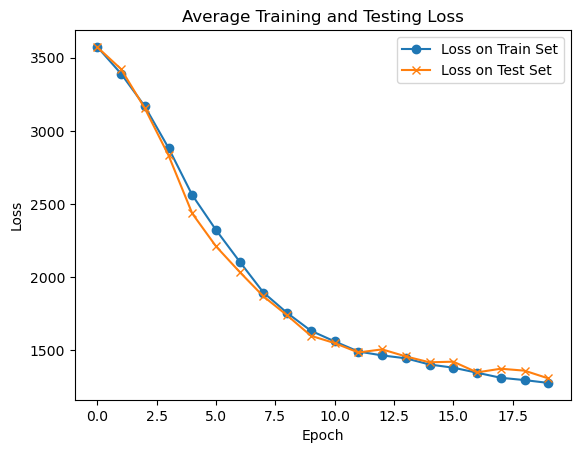

In [20]:
# print training and testing loss
plt.plot(train_losses, label='Loss on Train Set', marker='o')
plt.plot(test_losses, label='Loss on Test Set', marker='x')

# Setting the title and labels
plt.title('Average Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [21]:
# compute metrics for the trained model

# compute SSIM for train and test datasets
train_SSIM = compute_average_ssim(cvae, train_dataloader)
test_SSIM = compute_average_ssim(cvae, val_dataloader)
print(f"Train SSIM: {train_SSIM:.4f}")
print(f"Test SSIM: {test_SSIM:.4f}")

# compute FID for train and test dataset
train_fid = compute_fid(cvae, train_dataloader)
test_fid = compute_fid(cvae, val_dataloader)
print(f"Frechet Inception Distance (Train): {train_fid:.4f}")
print(f"Frechet Inception Distance (Test): {test_fid:.4f}")

Train SSIM: 0.1482
Test SSIM: 0.1388
Frechet Inception Distance (Train): 277.3145
Frechet Inception Distance (Test): 285.5428


**Visualize original and reconstructed images on test set for CVAE:**

In [22]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()

    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    plt.show()

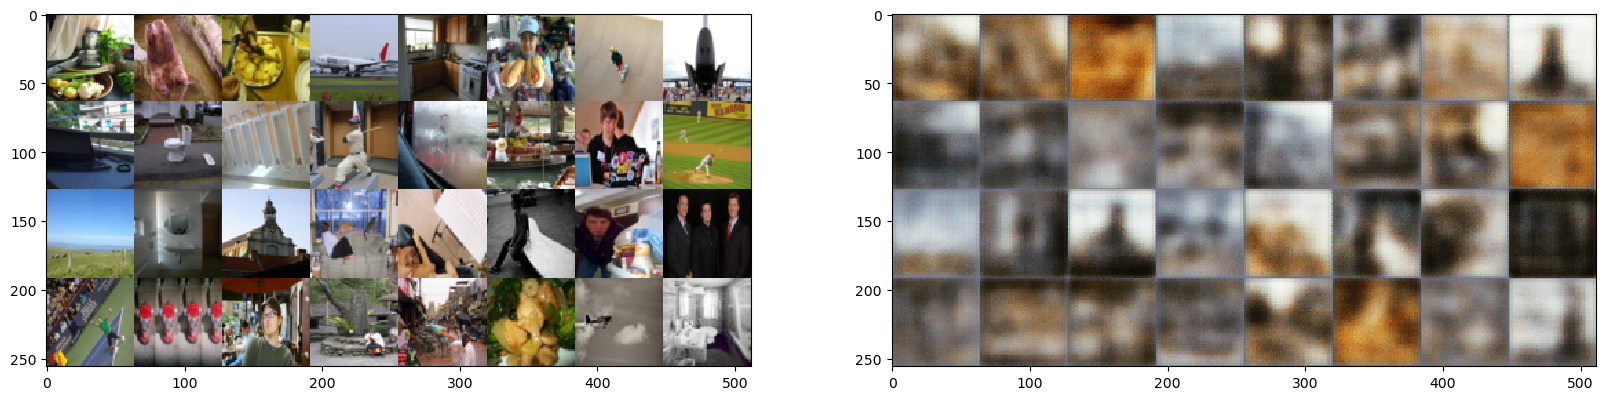

In [23]:
# get next batch of the dataloader
data, caption = next(iter(val_dataloader))
data_size = data.size()

# re-create images of the batch
text_embeddings = clip_encoder.encode_text(caption)
output, _, _ = cvae(data, text_embeddings)
output = output.detach()

# plot the first 32 images
data = data[:32]
output = output[:32]

# re-normalize
data = data * std + mean
output = output * std + mean

show(make_grid(data, padding=0), make_grid(output, padding=0))

**Save Model Weights:**

In [24]:
torch.save(cvae.state_dict(), "cvae_best_weights.pth")
print("CVAE Model weights saved to 'cvae_best_weights.pth'")

CVAE Model weights saved to 'cvae_best_weights.pth'


**Generate Images with Text Input**

In [25]:
def generate_images(model, text_encoder, text_input, n_samples=7):
    """
    Generates samples for a text input using the Conditional VAE.

    Args:
        model: The trained ConditionalVAE model.
        text_encoder: model used to create the text embeddings
        text input: what image should be generated.
        n_samples: Number of samples to generate.
        z_dim: Dimensionality of the latent space.

    Returns:
        Generated samples as a torch.Tensor.
    """
    model.eval()

    # 1. Sample latent variables from a standard normal distribution
    z = torch.randn(n_samples, latent_dim).to(device)  # (n_samples, latent_dim)

    # 2. Create the word embeddings
    text_embedding = text_encoder.encode_text(text_input)
    #print(f"Shape of text_embedding: {text_embedding.shape}")
    text_embeddings = text_embedding.repeat(n_samples, 1)

    # 3. Decode using the ConditionalVAE
    with torch.no_grad():
        generated_samples = model.decode(z, text_embeddings)

    return generated_samples

In [26]:
def show_generated_images(model, text_encoder, text_input, n_samples=7):

    # Generate samples
    generated_samples = generate_images(model, text_encoder, text_input, n_samples=7)
    generated_samples = generated_samples * std + mean

    # Set up the plot
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated_samples[i].permute(1, 2, 0).numpy())
        plt.axis('off')
    
    # Add the class name as the overall title
    plt.suptitle(f"Generated Samples for Caption: {text_input}", fontsize=16, y=1.05)

    # Adjust layout
    plt.tight_layout()
    plt.show()

Type Input Here: 


 airplane in the sky.


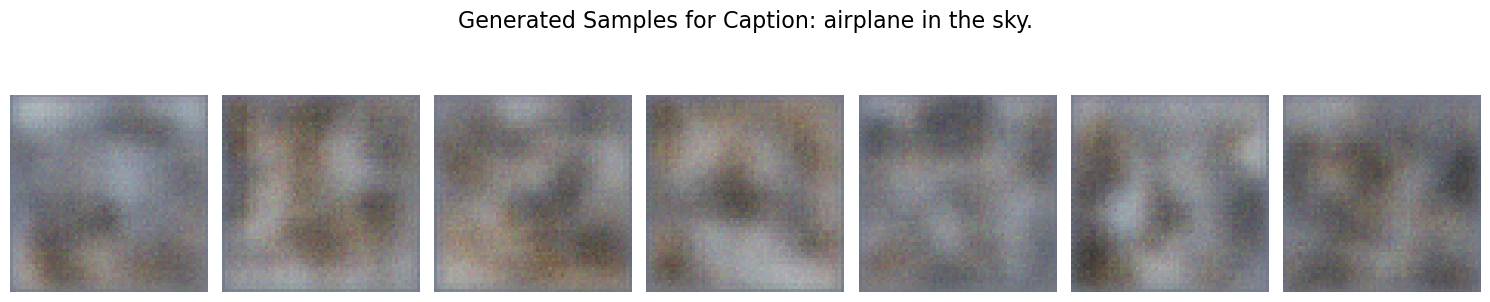

In [28]:
print('Type Input Here: ')
input_str = input()

show_generated_images(cvae, clip_encoder, input_str)